## Adding noise to dataset

In [1]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import keras
from keras.preprocessing import image
import time
import os
import shutil
#from tqdm import tqdm # for progress indication

Using TensorFlow backend.


In [2]:
# initilize input and outpur root directories
#inp_root_dir = 'D:/my_learning_dataset/state_farms_drivers/imgs_right/'
inp_root_dir = 'D:/my_learning_dataset/state_farms_drivers/imgs_right_cure_final/'
out_root_dir = 'D:/my_learning_dataset/state_farms_drivers/imgs_right_cure_final_noise/'
    
print("inp_root_dir: ", inp_root_dir)
print("out_root_dir: ", out_root_dir)

inp_root_dir:  D:/my_learning_dataset/state_farms_drivers/imgs_right_cure_final/
out_root_dir:  D:/my_learning_dataset/state_farms_drivers/imgs_right_cure_final_noise/


**basic class info**

In [3]:
# this is original image dataset for left hand driving
class_list =  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6','c7', 'c8', 'c9']
left_class_desc = ['safe driving', 'texting-right', 'talking on the phone-right', 'texting-left', 'talking on the phone-left', 
              'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
right_class_desc = ['safe driving', 'texting-left', 'talking on the phone-left', 'texting-right', 'talking on the phone-right', 
              'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
df_desc = pd.DataFrame({'class': class_list, 'left_desc': left_class_desc,  'right_desc': right_class_desc})
df_desc

,class,left_desc,right_desc
0,c0,safe driving,safe driving
1,c1,texting-right,texting-left
2,c2,talking on the phone-right,talking on the phone-left
3,c3,texting-left,texting-right
4,c4,talking on the phone-left,talking on the phone-right
5,c5,operating the radio,operating the radio
6,c6,drinking,drinking
7,c7,reaching behind,reaching behind
8,c8,hair and makeup,hair and makeup
9,c9,talking to passenger,talking to passenger


In [4]:
inp_train_dir = os.path.join(inp_root_dir, 'train')
inp_test_dir = os.path.join(inp_root_dir, 'test')

out_train_dir = os.path.join(out_root_dir, 'train')
out_test_dir = os.path.join(out_root_dir, 'test')

In [5]:
# input dataset summary
class_dirs = os.listdir(inp_train_dir)
for classname in class_dirs:
    print('{}: {} images'.format(classname, len(os.listdir(os.path.join(inp_train_dir, classname)))))

c0: 1472 images
c1: 1528 images
c2: 1527 images
c3: 1556 images
c4: 1587 images
c5: 1607 images
c6: 1529 images
c7: 1617 images
c8: 1489 images
c9: 1110 images


In [6]:
# fxn to create datafram for train dataset
def prepare_dataframe(train_dir):
    train = []
    class_dirs = os.listdir(inp_train_dir)
    for class_id, classname in enumerate(class_dirs):
        for file in os.listdir(os.path.join(train_dir, classname)):
            train.append(['{}/{}/{}'.format(train_dir, classname, file), class_id, classname])

    df_train = pd.DataFrame(train, columns=['file', 'class_id', 'classname'])
    return df_train

In [7]:
df_inp_train = prepare_dataframe(inp_train_dir)
print("shape: ", df_inp_train.shape)
df_inp_train.head(2)

shape:  (15022, 3)


,file,class_id,classname
0,D:/my_learning_dataset/state_farms_drivers/img...,0,c0
1,D:/my_learning_dataset/state_farms_drivers/img...,0,c0


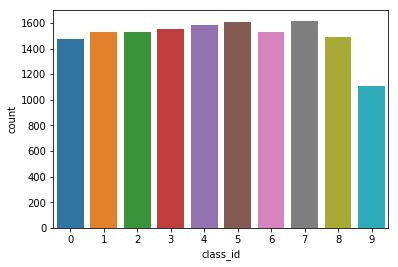

In [8]:
#plotting how the classes are distributed
sns.countplot(df_inp_train["class_id"])

In [9]:
# make this setting as 'yes" to created augeneted images'
DELETE_OLD_CONTENT = 'no'
#DELETE_OLD_CONTENT = 'yes'

In [10]:
# clear old content if any
if ((DELETE_OLD_CONTENT == 'yes') and os.path.exists(out_root_dir)):
    shutil.rmtree(out_root_dir)
    print('deleted directory and all its conetnt at : ', out_root_dir)

In [11]:
# create copy
shutil.copytree(inp_root_dir,out_root_dir)

'D:/my_learning_dataset/state_farms_drivers/imgs_right_cure_final_noise/'

In [12]:
# verify if all data is copied properly
df_out_train = prepare_dataframe(out_train_dir)
print("shape: ", df_out_train.shape)
df_out_train.head(2)

shape:  (15022, 3)


,file,class_id,classname
0,D:/my_learning_dataset/state_farms_drivers/img...,0,c0
1,D:/my_learning_dataset/state_farms_drivers/img...,0,c0


In [13]:
if(df_inp_train.shape[0] == df_out_train.shape[0]):
    print("All data copied properly")
else:
    print("All data not copied properly")

All data copied properly


In [14]:
import PIL

def img_flip(in_img_path, out_img_path):
    """
    Flip or mirror the image 
    @param in_img: source image file to flip
    @param out_img: Path to save the flip image file
    """
    image_obj = PIL.Image.open(in_img_path)
    flip_image = image_obj.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    flip_image.save(out_img_path)
    return

def img_gausian_blur(in_img_path, out_img_path, radius=2):
    image_obj = PIL.Image.open(in_img_path)
    img = image_obj.filter(PIL.ImageFilter.GaussianBlur(radius=radius))
    img.save(out_img_path)
    return

def img_sharpness(in_img_path, out_img_path, val=10):
    image_obj = PIL.Image.open(in_img_path)
    img = PIL.ImageEnhance.Sharpness(image_obj).enhance(val)
    img.save(out_img_path)
    return
             
def img_edge_enhance_more(in_img_path, out_img_path):
    image_obj = PIL.Image.open(in_img_path)
    img = image_obj.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
    img.save(out_img_path)
    return

# return new image object
def get_crop_border_portion_image(imgObj, percent):
   
    (width,height) = imgObj.size
    left = round(percent*width)
    upper = round(percent*height)
    
    left1 = round((1-percent)*width)
    upper1 = round((1-percent)*height)
    
    img = imgObj.crop((left,upper, left1, upper1))
    img = img.resize(imgObj.size)
    return img
             
def img_crop_border(in_img_path, out_img_path, val=0.20):
    image_obj = PIL.Image.open(in_img_path)
    img = get_crop_border_portion_image(image_obj, val)
    img.save(out_img_path)
    return
             
# return new image object
def get_shift_image(imgObj, direction, percent):
    
    (width,height) = imgObj.size
    
    if(direction == "UP"):
        left = 0
        upper = round(percent*height)    
        right = width
        bottom = height
    elif(direction == "DOWN"):
        left = 0
        upper = 0    
        right = width
        bottom = round((1-percent)*height)
    elif(direction == "LEFT"):
        left = round(percent*width)    
        upper = 0    
        right = width
        bottom = height
    elif(direction == "RIGHT"):
        left = 0    
        upper = 0    
        right = round((1-percent)*width)
        bottom = height
    else:
        left = 0    
        upper = 0    
        right = width
        bottom = height
    
    img = imgObj.crop((left,upper, right, bottom))
    img = img.resize(imgObj.size)
    return img

# direction = "UP", "DOWN", "LEFT", "RIGHT"
def img_shift(in_img_path, out_img_path, direction, val=0.10):
    image_obj = PIL.Image.open(in_img_path)
    img = get_shift_image(image_obj, direction, val)
    img.save(out_img_path)
    return
             
def img_brightness(in_img_path, out_img_path, val=5):
    image_obj = PIL.Image.open(in_img_path)
    img = PIL.ImageEnhance.Brightness(image_obj).enhance(val)
    img.save(out_img_path)
    return
             
# val=0: grayscale, non-zero is color
def img_color(in_img_path, out_img_path, val=0):
    image_obj = PIL.Image.open(in_img_path)
    img = PIL.ImageEnhance.Color(image_obj).enhance(val)
    img.save(out_img_path)
    return

In [15]:
import random 
import fnmatch

# control noise percentage as per need
def get_noise_per(cname):
    nper = 0.025
    if cname == "c9":
        nper = 0.08
    return nper

def create_img_gausian_blur(inp_dir, out_dir, radius):
    cdirs = os.listdir(inp_dir)
    for classname in cdirs:
        src_class_imgs = os.listdir(os.path.join(inp_dir, classname))
        noice_per = get_noise_per(classname)
        n_size = int(noice_per*len(src_class_imgs))
        random.shuffle(src_class_imgs) # suffle so that random image are considered for adding noise    
        for filename in src_class_imgs[:n_size]:
            src = '{}/{}/{}'.format(inp_dir, classname, filename)
            dst = '{}/{}/{}_gausian_blur.jpg'.format(out_dir, classname, filename)
            img_gausian_blur(src,dst, radius)

        outclassdir = os.path.join(out_dir, classname)
        filetype = '*_gausian_blur.jpg'
        n_out_files = len(fnmatch.filter(os.listdir(outclassdir),filetype))
        print("image blur ==> class: {}, {} images created..".format(classname, n_out_files))
    return

def create_img_sharpness(inp_dir, out_dir, val):
    cdirs = os.listdir(inp_dir)
    for classname in cdirs:
        src_class_imgs = os.listdir(os.path.join(inp_dir, classname))
        noice_per = get_noise_per(classname)
        n_size = int(noice_per*len(src_class_imgs))
        random.shuffle(src_class_imgs) # suffle so that random image are considered for adding noise    
        for filename in src_class_imgs[:n_size]:
            src = '{}/{}/{}'.format(inp_dir, classname, filename)
            dst = '{}/{}/{}_sharpness_{}.jpg'.format(out_dir, classname, filename,val)
            img_sharpness(src,dst,val)

        outclassdir = os.path.join(out_dir, classname)
        filetype = '*_sharpness_{}.jpg'.format(val)
        n_out_files = len(fnmatch.filter(os.listdir(outclassdir),filetype))
        print("shapemess (val={}) ==> class: {}, {} images created..".format(val, classname, n_out_files))
    return

def create_img_edge_enhance_more(inp_dir, out_dir):
    cdirs = os.listdir(inp_dir)
    for classname in cdirs:
        src_class_imgs = os.listdir(os.path.join(inp_dir, classname))
        noice_per = get_noise_per(classname)
        n_size = int(noice_per*len(src_class_imgs))
        random.shuffle(src_class_imgs) # suffle so that random image are considered for adding noise    
        for filename in src_class_imgs[:n_size]:
            src = '{}/{}/{}'.format(inp_dir, classname, filename)
            dst = '{}/{}/{}_edge_enhance_more.jpg'.format(out_dir, classname, filename)
            img_edge_enhance_more(src,dst)

        outclassdir = os.path.join(out_dir, classname)
        filetype = '*_edge_enhance_more.jpg'
        n_out_files = len(fnmatch.filter(os.listdir(outclassdir),filetype))
        print("edge_enhance_more ==> class: {}, {} images created..".format(classname, n_out_files))
    return

def create_img_crop_border(inp_dir, out_dir, val):
    cdirs = os.listdir(inp_dir)
    for classname in cdirs:
        src_class_imgs = os.listdir(os.path.join(inp_dir, classname))
        noice_per = get_noise_per(classname)
        n_size = int(noice_per*len(src_class_imgs))
        random.shuffle(src_class_imgs) # suffle so that random image are considered for adding noise    
        for filename in src_class_imgs[:n_size]:
            src = '{}/{}/{}'.format(inp_dir, classname, filename)
            dst = '{}/{}/{}_crop_border_{}.jpg'.format(out_dir, classname, filename,val)
            img_crop_border(src,dst,val)

        outclassdir = os.path.join(out_dir, classname)
        filetype = '*_crop_border_{}.jpg'.format(val)
        n_out_files = len(fnmatch.filter(os.listdir(outclassdir),filetype))
        print("crop_border (val={}) ==> class: {}, {} images created..".format(val, classname, n_out_files))
    return

def create_img_shift(inp_dir, out_dir, direction, val):
    cdirs = os.listdir(inp_dir)
    for classname in cdirs:
        src_class_imgs = os.listdir(os.path.join(inp_dir, classname))
        noice_per = get_noise_per(classname)
        n_size = int(noice_per*len(src_class_imgs))
        random.shuffle(src_class_imgs) # suffle so that random image are considered for adding noise    
        for filename in src_class_imgs[:n_size]:
            src = '{}/{}/{}'.format(inp_dir, classname, filename)
            dst = '{}/{}/{}_shift_{}_{}.jpg'.format(out_dir, classname, filename, direction, val)
            img_shift(src, dst, direction, val)

        outclassdir = os.path.join(out_dir, classname)
        filetype = '*_shift_{}_{}.jpg'.format(direction, val)
        n_out_files = len(fnmatch.filter(os.listdir(outclassdir),filetype))
        print("shift({}, val={}) ==> class: {}, {} images created..".format(direction, val, classname, n_out_files))
    return

def create_img_brightness(inp_dir, out_dir, val):
    cdirs = os.listdir(inp_dir)
    for classname in cdirs:
        src_class_imgs = os.listdir(os.path.join(inp_dir, classname))
        noice_per = get_noise_per(classname)
        n_size = int(noice_per*len(src_class_imgs))
        random.shuffle(src_class_imgs) # suffle so that random image are considered for adding noise    
        for filename in src_class_imgs[:n_size]:
            src = '{}/{}/{}'.format(inp_dir, classname, filename)
            dst = '{}/{}/{}_brightness_{}.jpg'.format(out_dir, classname, filename,val)
            img_brightness(src,dst,val)

        outclassdir = os.path.join(out_dir, classname)
        filetype = '*_brightness_{}.jpg'.format(val)
        n_out_files = len(fnmatch.filter(os.listdir(outclassdir),filetype))
        print("brightness (val={}) ==> class: {}, {} images created..".format(val, classname, n_out_files))
    return

In [16]:
print("Creating gausian blur images...")
create_img_gausian_blur(inp_train_dir, out_train_dir, radius=2)

print("Creating sharpness images...")
create_img_sharpness(inp_train_dir, out_train_dir, val=10)

print("Creating edge enhance more images...")
create_img_edge_enhance_more(inp_train_dir, out_train_dir)

print("Creating crop border images...")
create_img_crop_border(inp_train_dir, out_train_dir, val=0.20)

print("Creating shift UP images...")
create_img_shift(inp_train_dir, out_train_dir, direction="UP", val=0.10)

print("Creating brightness(5) images...")
create_img_brightness(inp_train_dir, out_train_dir,val=5)

print("Creating brightness(0.30) images...")
create_img_brightness(inp_train_dir, out_train_dir, val=0.30)


Creating gausian blur images...
image blur ==> class: c0, 36 images created..
image blur ==> class: c1, 38 images created..
image blur ==> class: c2, 38 images created..
image blur ==> class: c3, 38 images created..
image blur ==> class: c4, 39 images created..
image blur ==> class: c5, 40 images created..
image blur ==> class: c6, 38 images created..
image blur ==> class: c7, 40 images created..
image blur ==> class: c8, 37 images created..
image blur ==> class: c9, 88 images created..
Creating sharpness images...
shapemess (val=10) ==> class: c0, 36 images created..
shapemess (val=10) ==> class: c1, 38 images created..
shapemess (val=10) ==> class: c2, 38 images created..
shapemess (val=10) ==> class: c3, 38 images created..
shapemess (val=10) ==> class: c4, 39 images created..
shapemess (val=10) ==> class: c5, 40 images created..
shapemess (val=10) ==> class: c6, 38 images created..
shapemess (val=10) ==> class: c7, 40 images created..
shapemess (val=10) ==> class: c8, 37 images cre

In [17]:
# final: dataset summary
print("final: dataset summary")
class_dirs = os.listdir(out_train_dir)
for classname in class_dirs:
    print('{}: {} images'.format(classname, len(os.listdir(os.path.join(out_train_dir, classname)))))

final: dataset summary
c0: 1724 images
c1: 1794 images
c2: 1793 images
c3: 1822 images
c4: 1860 images
c5: 1887 images
c6: 1795 images
c7: 1897 images
c8: 1748 images
c9: 1726 images


In [18]:
df_final_train = prepare_dataframe(out_train_dir)
print("shape: ", df_final_train.shape)
df_final_train.head(2)

shape:  (18046, 3)


,file,class_id,classname
0,D:/my_learning_dataset/state_farms_drivers/img...,0,c0
1,D:/my_learning_dataset/state_farms_drivers/img...,0,c0


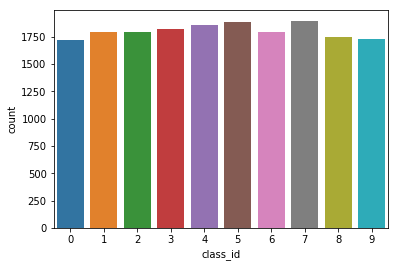

In [19]:
#plotting how the classes are distributed - new dataset with noise
sns.countplot(df_final_train["class_id"])

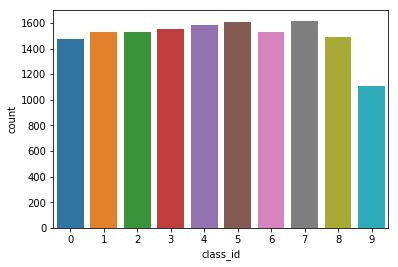

In [20]:
#plotting how the classes are distributed - current dataset without noise
sns.countplot(df_inp_train["class_id"])